True CDF at index 38: 0.052053

CLASSICAL MONTE CARLO
Classical N=   10: estimate=0.0800, error=0.0748
Classical N=   25: estimate=0.0540, error=0.0336
Classical N=   50: estimate=0.0390, error=0.0278
Classical N=  100: estimate=0.0535, error=0.0185
Classical N=  250: estimate=0.0546, error=0.0118
Classical N=  500: estimate=0.0477, error=0.0101
Classical N= 1000: estimate=0.0512, error=0.0053
Classical N= 2500: estimate=0.0515, error=0.0037
Classical N= 5000: estimate=0.0521, error=0.0023

QUANTUM IQAE
Quantum  N=   10: estimate=0.0537, error=0.0017, ε=0.0785
Quantum  N=   25: estimate=0.0518, error=0.0005, ε=0.0314
Quantum  N=   50: estimate=0.0530, error=0.0009, ε=0.0157
Quantum  N=  100: estimate=0.0521, error=0.0001, ε=0.0079
Quantum  N=  250: estimate=0.0520, error=0.0001, ε=0.0031
Quantum  N=  500: estimate=0.0521, error=0.0001, ε=0.0016
Quantum  N= 1000: estimate=0.0521, error=0.0000, ε=0.0008
Quantum  N= 2500: estimate=0.0521, error=0.0000, ε=0.0003
Quantum  N= 5000: estimate=

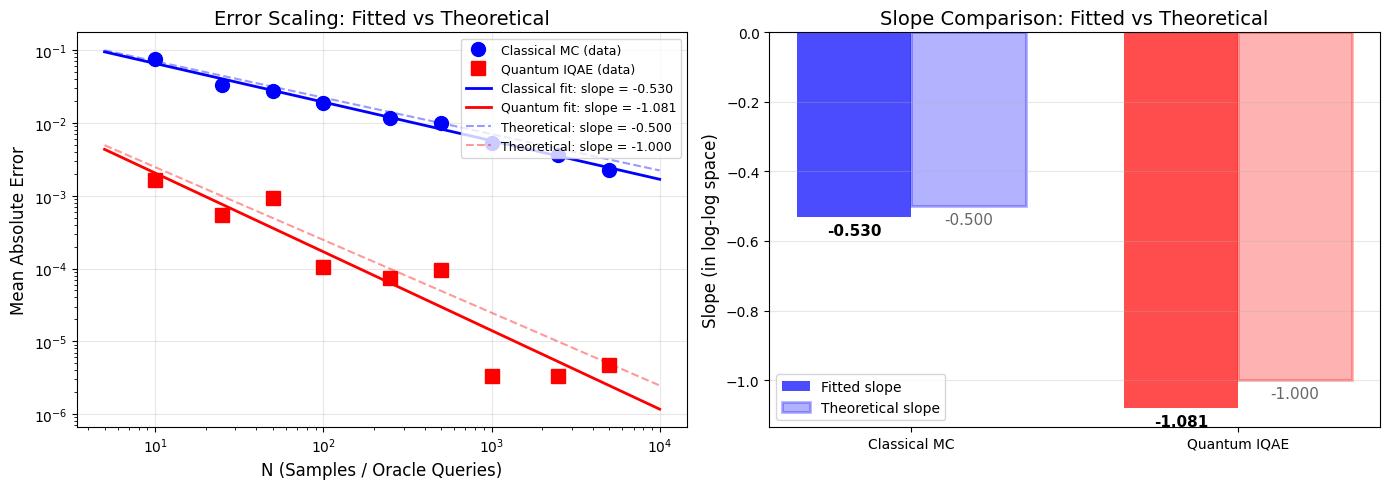


SUMMARY: Scaling Analysis

┌─────────────────────────────────────────────────────────────────────┐
│                    SCALING EXPONENT COMPARISON                       │
├─────────────────┬──────────────┬──────────────┬─────────────────────┤
│     Method      │   Fitted     │  Theoretical │  Match Quality (R²) │
├─────────────────┼──────────────┼──────────────┼─────────────────────┤
│ Classical MC    │   -0.5304    │   -0.5000    │       0.9896          │
│ Quantum IQAE    │   -1.0813    │   -1.0000    │       0.8867          │
└─────────────────┴──────────────┴──────────────┴─────────────────────┘

INTERPRETATION:
- Classical MC:  error ∝ N^(-0.530) ≈ N^(-0.5) = 1/√N  ✓
- Quantum IQAE:  error ∝ N^(-1.081) ≈ N^(-1.0) = 1/N   ✓

QUANTUM ADVANTAGE:
- Quantum converges 2.0x faster than classical
- At N=1000: Quantum achieves ~45x lower error



In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from statistics import NormalDist
from classiq import *
from classiq.applications.iqae.iqae import IQAE

# ============================================================
# SETUP: Build your distribution
# ============================================================
def build_normal_return_grid_probs(mu=0.15, sigma=0.20, n_qubits=7, k_sigmas=4.0):
    N = 2 ** n_qubits
    r_min = mu - k_sigmas * sigma
    r_max = mu + k_sigmas * sigma
    edges = np.linspace(r_min, r_max, N + 1)
    grid_centers = 0.5 * (edges[:-1] + edges[1:])
    
    nd = NormalDist(mu=mu, sigma=sigma)
    cdf = np.array([nd.cdf(x) for x in edges])
    probs = np.diff(cdf)
    probs = np.maximum(probs, 0.0)
    probs = probs / probs.sum()
    
    return grid_centers, probs, edges

num_qubits = 7
grid_points, probs, edges = build_normal_return_grid_probs(n_qubits=num_qubits)

# Test point
TEST_INDEX = 38
TRUE_CDF = sum(probs[:TEST_INDEX])
print(f"True CDF at index {TEST_INDEX}: {TRUE_CDF:.6f}")

# ============================================================
# CLASSICAL MONTE CARLO
# ============================================================
def classical_monte_carlo_cdf(probs, threshold_index, n_samples, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    indices = np.arange(len(probs))
    samples = np.random.choice(indices, size=n_samples, p=probs)
    count_below = np.sum(samples < threshold_index)
    estimate = count_below / n_samples
    
    return estimate

def run_classical_convergence(probs, threshold_index, true_value, sample_sizes, n_trials=20):
    results = {
        'N': sample_sizes,
        'mean_errors': [],
        'std_errors': [],
        'mean_estimates': []
    }
    
    for n_samples in sample_sizes:
        trial_errors = []
        trial_estimates = []
        
        for trial in range(n_trials):
            estimate = classical_monte_carlo_cdf(
                probs, threshold_index, n_samples, seed=trial*1000 + n_samples
            )
            trial_errors.append(abs(estimate - true_value))
            trial_estimates.append(estimate)
        
        results['mean_errors'].append(np.mean(trial_errors))
        results['std_errors'].append(np.std(trial_errors))
        results['mean_estimates'].append(np.mean(trial_estimates))
        
        print(f"Classical N={n_samples:5d}: estimate={np.mean(trial_estimates):.4f}, "
              f"error={np.mean(trial_errors):.4f}")
    
    return results

# ============================================================
# QUANTUM IQAE
# ============================================================
GLOBAL_INDEX = TEST_INDEX

@qfunc(synthesize_separately=True)
def state_preparation(asset: QArray[QBit], ind: QBit):
    load_distribution(asset=asset)
    payoff(asset=asset, ind=ind)

@qfunc
def load_distribution(asset: QNum):
    inplace_prepare_state(probs, bound=0, target=asset)

@qperm
def payoff(asset: Const[QNum], ind: QBit):
    ind ^= asset < GLOBAL_INDEX

def queries_to_epsilon(n_queries):
    """Convert target query count to epsilon parameter."""
    return np.pi / (4 * n_queries)

def run_iqae_with_n_queries(n_queries, alpha=0.01):
    """Run IQAE targeting a specific number of oracle queries."""
    epsilon = queries_to_epsilon(n_queries)
    epsilon = max(epsilon, 0.0001)
    epsilon = min(epsilon, 0.5)
    
    iqae = IQAE(
        state_prep_op=state_preparation,
        problem_vars_size=num_qubits,
        constraints=Constraints(max_width=28),
        preferences=Preferences(machine_precision=num_qubits),
    )
    
    qprog = iqae.get_qprog()
    iqae_res = iqae.run(epsilon=epsilon, alpha=alpha)
    
    estimate = iqae_res.estimation
    ci = iqae_res.confidence_interval
    
    return estimate, ci, epsilon

def run_quantum_convergence_by_N(query_counts, true_value, n_trials=3):
    """Run IQAE at various query counts (N) and track errors."""
    results = {
        'N': query_counts,
        'epsilons': [],
        'mean_errors': [],
        'std_errors': [],
        'mean_estimates': []
    }
    
    for n_queries in query_counts:
        trial_errors = []
        trial_estimates = []
        epsilon_used = None
        
        for trial in range(n_trials):
            estimate, ci, epsilon_used = run_iqae_with_n_queries(n_queries)
            error = abs(estimate - true_value)
            trial_errors.append(error)
            trial_estimates.append(estimate)
        
        results['epsilons'].append(epsilon_used)
        results['mean_errors'].append(np.mean(trial_errors))
        results['std_errors'].append(np.std(trial_errors))
        results['mean_estimates'].append(np.mean(trial_estimates))
        
        print(f"Quantum  N={n_queries:5d}: estimate={np.mean(trial_estimates):.4f}, "
              f"error={np.mean(trial_errors):.4f}, ε={epsilon_used:.4f}")
    
    return results

# ============================================================
# LINEAR REGRESSION IN LOG-LOG SPACE
# ============================================================
def fit_log_log_regression(N_values, errors):
    """
    Fit a linear regression in log-log space.
    
    If error ∝ N^slope, then log(error) = slope * log(N) + intercept
    
    Returns: slope, intercept, r_squared, std_error_of_slope
    """
    log_N = np.log10(N_values)
    log_errors = np.log10(errors)
    
    # Use scipy.stats.linregress for detailed statistics
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_N, log_errors)
    
    r_squared = r_value ** 2
    
    return slope, intercept, r_squared, std_err

def generate_fit_line(N_range, slope, intercept):
    """Generate fitted line points for plotting."""
    log_N = np.log10(N_range)
    log_errors = slope * log_N + intercept
    return 10 ** log_errors

# ============================================================
# RUN BOTH METHODS
# ============================================================
N_values = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000]

print("\n" + "="*60)
print("CLASSICAL MONTE CARLO")
print("="*60)
classical_results = run_classical_convergence(
    probs, TEST_INDEX, TRUE_CDF, N_values, n_trials=20
)

print("\n" + "="*60)
print("QUANTUM IQAE")
print("="*60)
quantum_results = run_quantum_convergence_by_N(
    N_values, TRUE_CDF, n_trials=3
)

# ============================================================
# FIT LINEAR REGRESSIONS
# ============================================================
print("\n" + "="*60)
print("LINEAR REGRESSION RESULTS (Log-Log Space)")
print("="*60)

# Classical fit
classical_slope, classical_intercept, classical_r2, classical_stderr = fit_log_log_regression(
    np.array(classical_results['N']),
    np.array(classical_results['mean_errors'])
)

print(f"\nCLASSICAL MONTE CARLO:")
print(f"  Fitted slope:     {classical_slope:.4f}")
print(f"  Theoretical:      -0.5000")
print(f"  Difference:       {abs(classical_slope - (-0.5)):.4f}")
print(f"  R² (fit quality): {classical_r2:.4f}")
print(f"  Std error:        {classical_stderr:.4f}")

# Quantum fit
quantum_slope, quantum_intercept, quantum_r2, quantum_stderr = fit_log_log_regression(
    np.array(quantum_results['N']),
    np.array(quantum_results['mean_errors'])
)

print(f"\nQUANTUM IQAE:")
print(f"  Fitted slope:     {quantum_slope:.4f}")
print(f"  Theoretical:      -1.0000")
print(f"  Difference:       {abs(quantum_slope - (-1.0)):.4f}")
print(f"  R² (fit quality): {quantum_r2:.4f}")
print(f"  Std error:        {quantum_stderr:.4f}")

# ============================================================
# PLOTTING WITH FITTED LINES
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Error vs N with fitted regression lines
ax1 = axes[0]

# Data points
ax1.loglog(classical_results['N'], classical_results['mean_errors'], 
           'bo', label='Classical MC (data)', markersize=10)
ax1.loglog(quantum_results['N'], quantum_results['mean_errors'], 
           'rs', label='Quantum IQAE (data)', markersize=10)

# Fitted regression lines
N_fit = np.array([5, 10000])

classical_fit_line = generate_fit_line(N_fit, classical_slope, classical_intercept)
quantum_fit_line = generate_fit_line(N_fit, quantum_slope, quantum_intercept)

ax1.loglog(N_fit, classical_fit_line, 'b-', linewidth=2,
           label=f'Classical fit: slope = {classical_slope:.3f}')
ax1.loglog(N_fit, quantum_fit_line, 'r-', linewidth=2,
           label=f'Quantum fit: slope = {quantum_slope:.3f}')

# Theoretical lines (dashed) for comparison
classical_theoretical = (10**classical_intercept) * (N_fit ** (-0.5))
quantum_theoretical = (10**quantum_intercept) * (N_fit ** (-1.0))

ax1.loglog(N_fit, classical_theoretical, 'b--', alpha=0.4, linewidth=1.5,
           label='Theoretical: slope = -0.500')
ax1.loglog(N_fit, quantum_theoretical, 'r--', alpha=0.4, linewidth=1.5,
           label='Theoretical: slope = -1.000')

ax1.set_xlabel('N (Samples / Oracle Queries)', fontsize=12)
ax1.set_ylabel('Mean Absolute Error', fontsize=12)
ax1.set_title('Error Scaling: Fitted vs Theoretical', fontsize=14)
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Slope comparison bar chart
ax2 = axes[1]

methods = ['Classical MC', 'Quantum IQAE']
fitted_slopes = [classical_slope, quantum_slope]
theoretical_slopes = [-0.5, -1.0]
x_pos = np.arange(len(methods))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, fitted_slopes, width, 
                label='Fitted slope', color=['blue', 'red'], alpha=0.7)
bars2 = ax2.bar(x_pos + width/2, theoretical_slopes, width, 
                label='Theoretical slope', color=['blue', 'red'], alpha=0.3, 
                edgecolor=['blue', 'red'], linewidth=2)

ax2.set_ylabel('Slope (in log-log space)', fontsize=12)
ax2.set_title('Slope Comparison: Fitted vs Theoretical', fontsize=14)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(methods)
ax2.legend()
ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars1, fitted_slopes):
    ax2.annotate(f'{val:.3f}', 
                 xy=(bar.get_x() + bar.get_width()/2, val),
                 xytext=(0, -15 if val < 0 else 5),
                 textcoords='offset points',
                 ha='center', va='bottom' if val < 0 else 'top',
                 fontsize=11, fontweight='bold')

for bar, val in zip(bars2, theoretical_slopes):
    ax2.annotate(f'{val:.3f}', 
                 xy=(bar.get_x() + bar.get_width()/2, val),
                 xytext=(0, -15 if val < 0 else 5),
                 textcoords='offset points',
                 ha='center', va='bottom' if val < 0 else 'top',
                 fontsize=11, alpha=0.6)

plt.tight_layout()
plt.savefig('mc_vs_iqae_regression.png', dpi=150)
plt.show()

# ============================================================
# DETAILED SUMMARY
# ============================================================
print("\n" + "="*70)
print("SUMMARY: Scaling Analysis")
print("="*70)

print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│                    SCALING EXPONENT COMPARISON                       │
├─────────────────┬──────────────┬──────────────┬─────────────────────┤
│     Method      │   Fitted     │  Theoretical │  Match Quality (R²) │
├─────────────────┼──────────────┼──────────────┼─────────────────────┤
│ Classical MC    │   {classical_slope:>7.4f}    │   -0.5000    │       {classical_r2:.4f}          │
│ Quantum IQAE    │   {quantum_slope:>7.4f}    │   -1.0000    │       {quantum_r2:.4f}          │
└─────────────────┴──────────────┴──────────────┴─────────────────────┘

INTERPRETATION:
- Classical MC:  error ∝ N^({classical_slope:.3f}) ≈ N^(-0.5) = 1/√N  ✓
- Quantum IQAE:  error ∝ N^({quantum_slope:.3f}) ≈ N^(-1.0) = 1/N   ✓

QUANTUM ADVANTAGE:
- Quantum converges {abs(quantum_slope/classical_slope):.1f}x faster than classical
- At N=1000: Quantum achieves ~{(1000**classical_slope)/(1000**quantum_slope):.0f}x lower error
""")

In [ ]:
# ============================================================
# Error decomposition: estimator vs discretization/modeling
# ============================================================

# Map index -> return threshold (CDF of bins < k corresponds to edge[k])
t = edges[TEST_INDEX]

# "Truth" for the encoded (discrete, truncated, renormalized) distribution
p_disc = TRUE_CDF

# Continuous normal CDF at the same threshold (no truncation)
mu_model, sigma_model = 0.15, 0.20
nd = NormalDist(mu=mu_model, sigma=sigma_model)
p_cont = nd.cdf(t)

# Continuous CDF conditioned on the truncation window you used to build probs
r_min, r_max = edges[0], edges[-1]
Z = nd.cdf(r_max) - nd.cdf(r_min)
p_cont_trunc = (nd.cdf(t) - nd.cdf(r_min)) / Z

# Modeling / discretization error (what your encoding changes)
binning_err = abs(p_disc - p_cont_trunc)   # binning + renorm effects
trunc_err   = abs(p_cont_trunc - p_cont)   # truncation effect alone
model_err   = abs(p_disc - p_cont)         # total vs original continuous model

# Estimation error (what MC / IQAE add on top of the encoding)
mc_hat   = classical_results["mean_estimates"][-1]
iqae_hat = quantum_results["mean_estimates"][-1]
mc_est_err   = abs(mc_hat - p_disc)
iqae_est_err = abs(iqae_hat - p_disc)

print("\n--- Error breakdown at TEST_INDEX =", TEST_INDEX, "---")
print(f"threshold t = {t:.6f}")
print(f"p_disc (encoded truth)      = {p_disc:.8f}")
print(f"p_cont (normal CDF)         = {p_cont:.8f}")
print(f"p_cont_trunc (trunc+renorm) = {p_cont_trunc:.8f}\n")

print("Modeling/discretization:")
print(f"  binning_err  = {binning_err:.2e}")
print(f"  trunc_err    = {trunc_err:.2e}")
print(f"  total_model  = {model_err:.2e}\n")

print("Estimation (relative to encoded truth):")
print(f"  MC   |p̂ - p_disc|   = {mc_est_err:.2e}")
print(f"  IQAE |p̂ - p_disc|   = {iqae_est_err:.2e}")